# Migration Examples
Examples of increasingly complex models using somata migration:
- simple migration: just a soma migrating from left to right: [Simple_migration](#Simple_migration)
- multiple migration: 50 somata moving randomly: [Multiple_migration](#Multiple_migration)
- filipod migration: substrate attracts filipodia that guide the somata towards the attractor, where they sprout dendrites: [Filipod_migration](#Filipod_migration)
- filipod and axon migration: the migrating somata also leave behind a trailing axon: [Filipod_axon_migration](#Filipod_axon_migration)
- filipod is colored: filipod color represents local attractor concentration: [Colored_migration](#Colored_migration)
- filipod and axon migrationwith block: same as before but the migrating soma have to migrate around blocking structures: [Filipod_axon_block_migration](#Filipod_axon_block_migration)

## Simple_migration
A single soma migrates from left to right

<IPython.core.display.Javascript object>


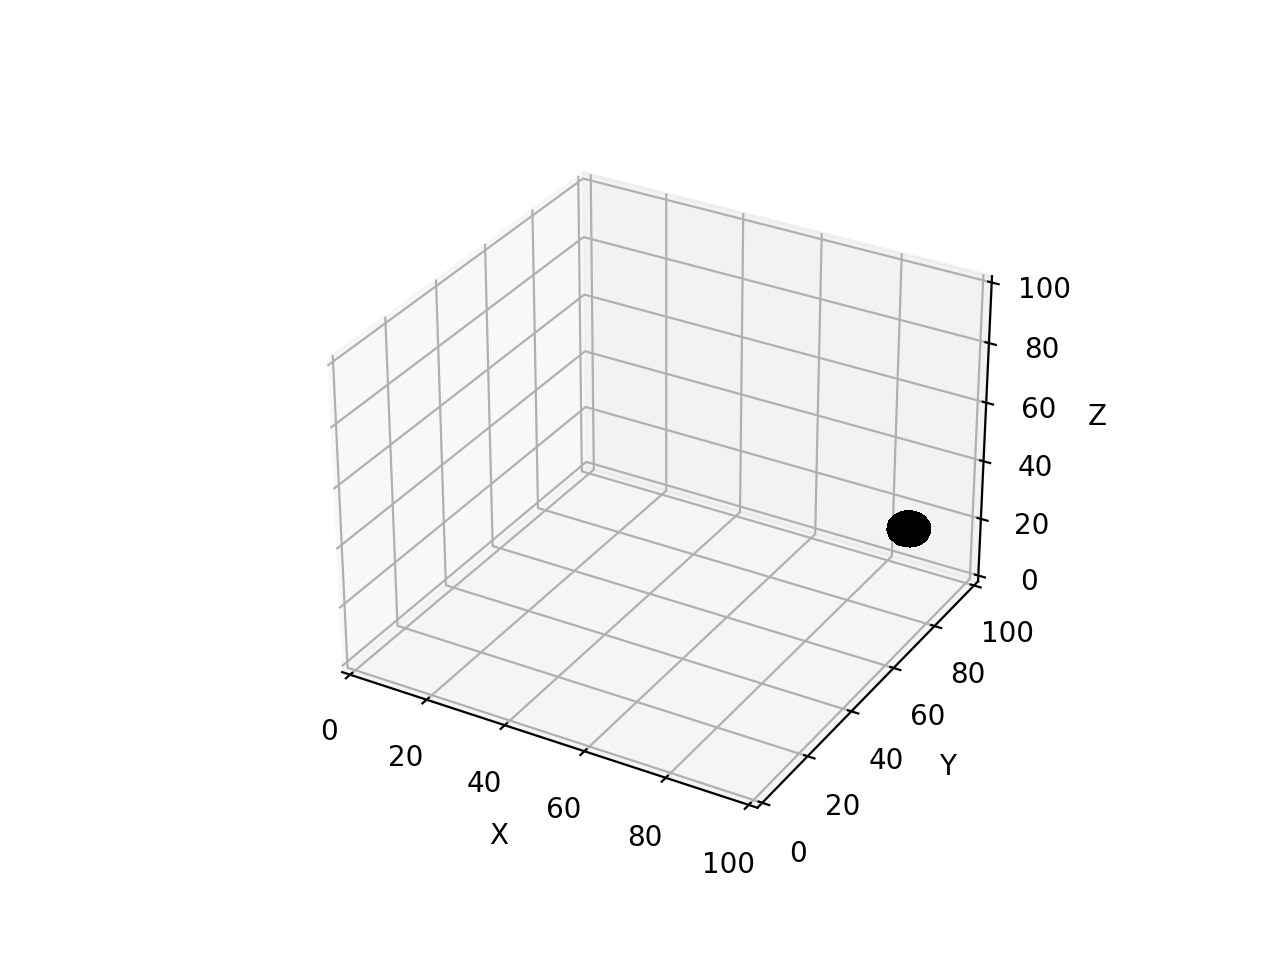

In [1]:
%matplotlib notebook

from neurodevsim.simulator import *

class MigrationFront(Front):
    
    # No additional fronts made
    def manage_front(self,constellation):
        if self.orig.x < 95:
            pos = self.orig + Point(4.,2.,0.)
            self.migrate_soma(constellation,pos)
        else:
            self.disable(constellation)

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/migration.db"
    sim_volume = [[0., 0., 0.], [100.0,100.0,100.0]]
    neuron_types = [MigrationFront]
    admin = Admin_agent(1,fname,sim_volume,neuron_types,verbose=0,plot=True)

    # make soma and set neuron name
    admin.add_neurons(MigrationFront,"neuron",1,[[10,50,20],[10,50,20]],5.,migrating=True)

    # run the simulation
    admin.simulation_loop(20)

    # clean up
    admin.destruction()



## Multiple_migration
A 50 somata migrate randomly until they reach bottom of the volume where they stop.

<IPython.core.display.Javascript object>


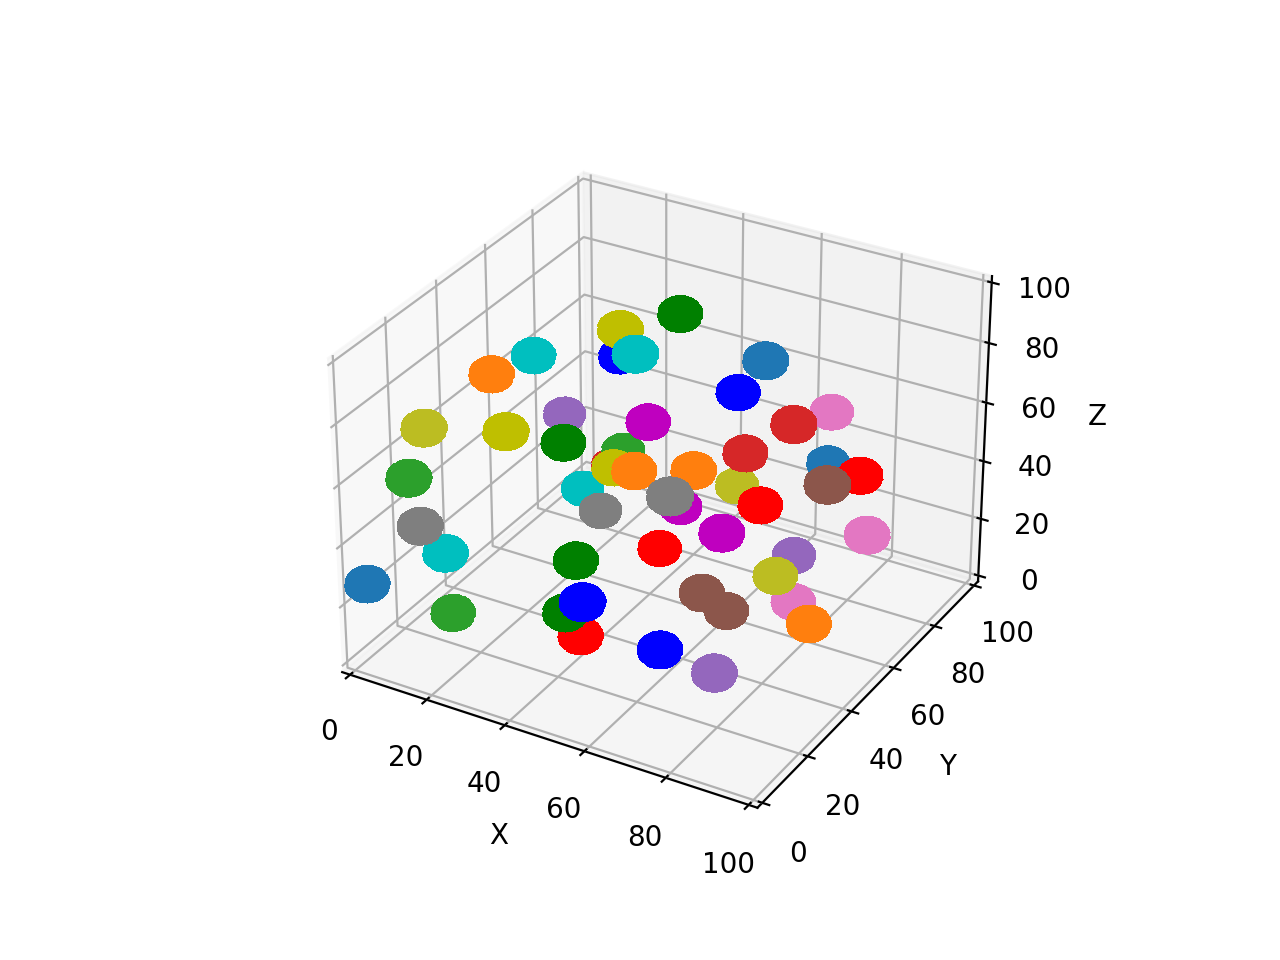

In [2]:
%matplotlib notebook

from neurodevsim.simulator import *

class MigrationFront(Front):
    
    # No additional fronts made
    def manage_front(self,constellation):
        if self.orig.z < 10.: # stop at the bottom
            self.disable(constellation)
            return
        while True: # keep trying till success
            try:
                new_pos = self.orig + unit_sample_on_sphere() * 5.
                self.migrate_soma(constellation,new_pos)
                return
            except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                continue

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/50migration.db"
    sim_volume = [[0., 0., 0.], [100.0,100.0,100.0]]
    neuron_types = [MigrationFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,seed=1,plot=True,soma_black=False)

    # make 50 somata and set neuron name
    admin.add_neurons(MigrationFront,"neuron",50,[[10,10,10],[90,90,90]],5.,migrating=True)

    # run the simulation
    admin.simulation_loop(40)

    # clean up
    admin.destruction()

## Filipod_migration
Substrate attracts filipodia that guide five somata towards an attractor, where they sprout dendrites.  
This is fairly complex code that manages filipodia and migrating somata separately most of the time.  
At one instance communication between leading filipodium and soma is necessary: upon arrival at the attractor the filipodia stops growing and it needs to communicate this to the soma. This is done using the ``is_status1()`` method with the filipod setting *status1* in the soma. Because this can happen only once for each neuron it is a safe use of setting an attribute in another front.  
Filipodia growth uses ``solve_collision`` to deal with collisions.

<IPython.core.display.Javascript object>


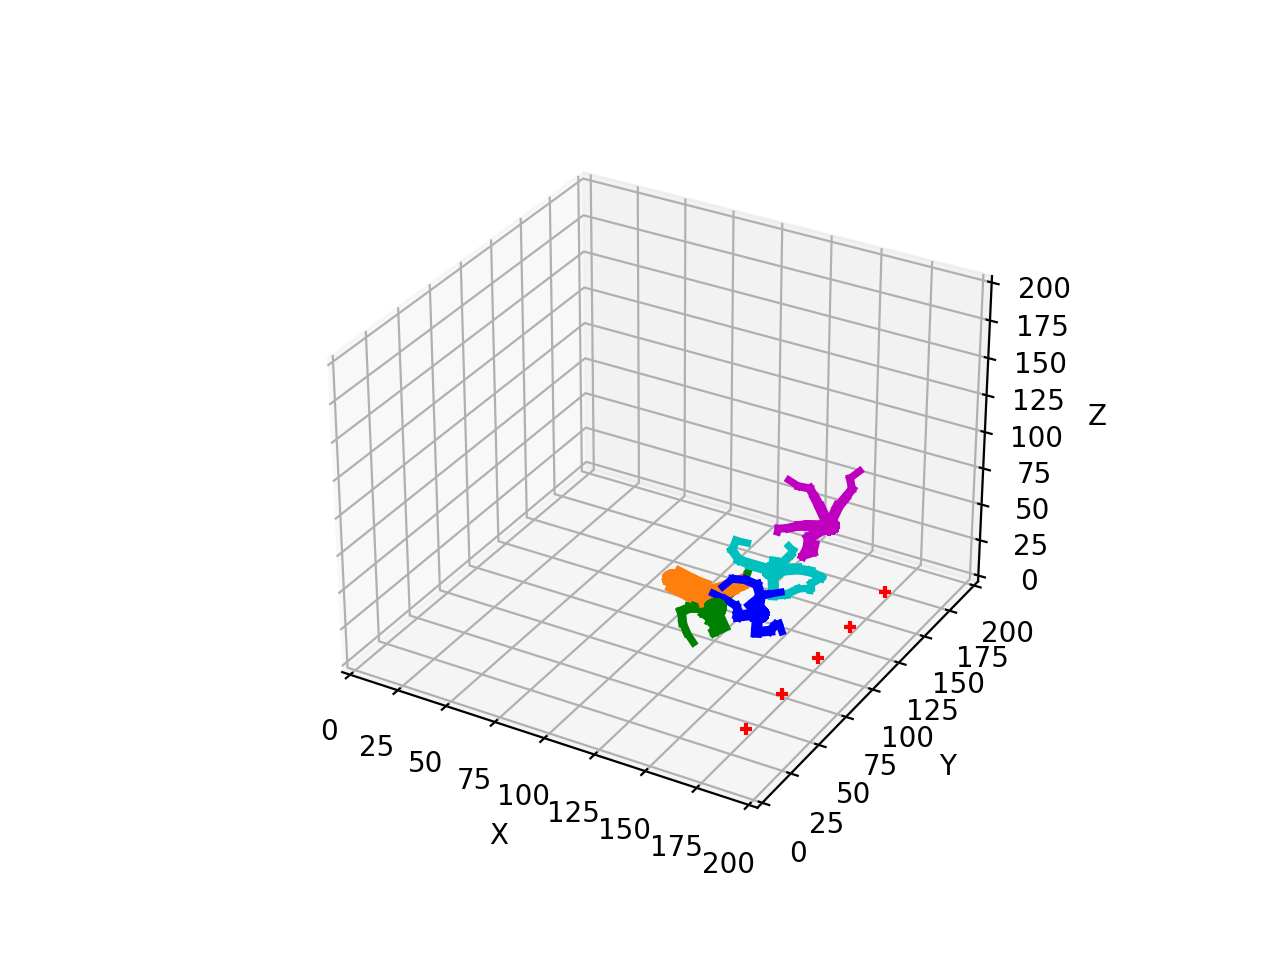

In [3]:
%matplotlib notebook

from neurodevsim.simulator import *
import numpy as np

class FMigrationFront(Front):
    
    # manage_front calls appropriate method depending on swc_type
    def manage_front(self,constellation):
        if self.swc_type == 1: # soma: check whether it can migrate or grow filipod or dendrites
            self.manage_soma(constellation)
        elif self.swc_type == 12: # filipod: grow it unless very close to attractor
            self.grow_filipod(constellation)
        elif self.swc_type == 3: # dendrites
            self.grow_dendrite(constellation)
        else:
            print ("Error: unexpected condition in extend_front")
    
    # migrate soma of grow filipod or dendrites
    def manage_soma(self,constellation):
        # first check whether we should migrate
        if self.num_children == 1: # a filipod child is present
            children = self.get_children(constellation) # get the filipod child
            filipod = children[0]
            if (filipod.num_children == 1) or self.is_status1(): # filipod has a child or arrived -> migrate
                # migrate to filipod position
                try:
                    coordinate = self.migrate_soma(constellation,None,filipod=True)
                    # success -> self.has_moved() is True
                except (GridCompetitionError):
                    #print ("Error:",self.get_neuron_name(constellation),"soma GridCompetitionError",self.has_moved())                    
                    return # try again next cycle
                except (CollisionError,ActiveChildError):
                    print ("Error:",self.get_neuron_name(constellation),"soma cannot migrate",self.has_moved())                    
                    # try again next cycle if this is the first instance
                    if (not self.has_moved()) and (self.orig.x > 50.): # second failed attempt: delete filipod
                        print (self.get_neuron_name(constellation),"soma retracts filipodium")
                        self.retract_branch(constellation,filipod)
        elif self.num_children == 0: # no filipod child: either make filipod of dendrites
            if constellation.cycle == 1: # make first filipod child, fixed growth
                new_pos = self.orig + Point(10.,2.,0)
                # there should be no obstruction on first growth
                try:
                    new_front = self.add_child(constellation,new_pos,radius=1.5,swc_type=12,branch_name="filipod")
                except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                    print ("Error:",self.get_neuron_name(constellation),"soma cannot make initial filipodium")
                return #done
            # check whether arrived to attractor
            if self.is_status1(): # filipod flagged arrival
                points = self.unit_branching_sample(10) # generate more points than needed
                num_dend = 0 # count number of dendrites
                for p in points: # make 4 dendrites
                    new_pos = self.orig + p * (6.0 + self.radius)
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=2.0,swc_type=3,branch_name="dendrite")
                        num_dend += 1
                        if num_dend == 4: # enough dendrites made
                            # make soma inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            return # completed this call
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                         continue # pick another point, no attempt to correct the error
            else: # make a filipod based on attraction
                self.grow_filipod(constellation)
        else:
            print ("Error:",self.get_neuron_name(constellation),"child count",self.num_children)                    
   
    # check whether filipod should continue to grow and do so
    def grow_filipod(self,constellation):
        # attract by attractor, get distant information
        attraction = self.get_substrates(constellation,"attractor",max_distance=200)
        if attraction: # attractor detected: check concentration
            n_mols,adir = diff_gradient_to(self.end,attraction,constellation.cycle)
            # negative x means we passed the attractor
            if (adir.x < 0) or (n_mols >= 3800): # close to attractor, end filipod growth
                soma = self.get_soma(constellation)
                soma.set_status1() # flag soma that filipod has arrived: safe because nobody else sets flag
                self.disable(constellation)
                return # no growth
        else:
            n_mols = 0
        max_count = 50
         # try to make a new filipod
        count = 0
        while count < max_count:
            rnd_dir = self.unit_heading_sample(width=min(90.,10. + 2.*count))
            if n_mols == 0:  # cannot be detected
                if self.swc_type == 1: # call by the soma: no heading
                    new_pos = self.orig + Point(10.,2.,0) + rnd_dir
                else:
                    new_pos = self.end + rnd_dir * 2.0
            elif n_mols < 50: # far away: scale noise to n_mols
                scale = min(5.5,n_mols*0.1)
                new_pos = self.end + rnd_dir * (6.0-scale) + adir * scale 
            elif n_mols < 3800: # closer: limit noise if not colliding
                scale = max(0.1,count*0.5)
                new_pos = self.end + rnd_dir * scale + adir * (6.0-scale) 
            else: # arrived
                print ("Error in arrived",self.get_neuron_name(constellation))
            # check for possible collisions
            try:
                new_front = self.add_child(constellation,new_pos,radius=1.5,swc_type=12,branch_name="filipod")
                if self.swc_type == 12: 
                    self.disable(constellation) # success -> disable self if filipod
                return # success
            except (GridCompetitionError,InsideParentError,VolumeError):
                count += 1
                continue # generate another new_pos, no attempt to correct the error
            except CollisionError as error:
                #if count == 0:
                    #print (self.get_neuron_name(constellation),self._fid,n_mols,"fili collides with",error.collider)
                if error.collider.is_migrating(): # collision with another migrating soma
                    # best strategy is to wait till this front has passed
                    return
                count += 1
                points = self.solve_collision(constellation,new_pos,error,half_arc=True)
                #print (self.get_neuron_name(constellation),count,self._fid,"soma-fili solve_collision returns",points)
                if points: # one or more points was returned
                    try:
                        new_fronts = self.add_branch(constellation,points)
                        self.disable(constellation) # success -> disable self
                        return # success
                    except CollisionError as error:
                        #print (self.get_neuron_name(constellation),self._fid,"soma-fili solve_collision collides with",error.collider)
                        continue # generate another new_pos, no attempt to correct the error
                    except (GridCompetitionError,InsideParentError,\
                                                        VolumeError):
                        #print (self.get_neuron_name(constellation),self._fid,"soma-fili solve_collision other error")
                        continue # generate another new_pos, no attempt to correct the error
        # growth failed
        if (self.swc_type == 12) and ((constellation.cycle - self.birth) > 2): # this was second failed attempt
            self.enable_parent(constellation,growing=True) # make parent filipod grow again
            self.retract(constellation) # retract this front

    # check whether dendrite should continue to grow and do so
    def grow_dendrite(self,constellation):
        if self.path_length >= 30:  # terminus: stop growing
            self.disable(constellation)
            return
        count = 0
        while count < 50:
            # random component
            rnd_dir = self.unit_heading_sample()
            new_pos = self.end + rnd_dir * 6.0
            rad = self.taper(0.9)
            # check for possible collisions
            try:
                new_front = self.add_child(constellation,new_pos,radius=rad)
                self.disable(constellation) # success -> disable self
                return
            except CollisionError as error:
                points = self.solve_collision(constellation,new_pos,error,half_arc=True)
                #print (self.get_neuron_name(constellation),"dend solve_collision returns",points)
                if points: # one or more points was returned
                    try:
                        new_fronts = self.add_branch(constellation,points)
                        self.disable(constellation) # success -> disable self
                        return
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                        count += 1
                        continue # generate another new_pos, no attempt to correct the error
                else:
                    count += 1
                    continue # generate another new_pos
            except (GridCompetitionError,InsideParentError,VolumeError):
                count += 1
                continue # generate another new_pos, no attempt to correct the error
        # failed but do not consider this as an error
        if (constellation.cycle - self.birth) > 2: # this was second failed attempt
            self.disable(constellation) # stop trying
            
if __name__ == '__main__':
    # initialize Admin_agent
    fname = "output/fmigration.db"
    sim_volume = [[0., 0., 0.], [200.0,200.0,200.0]]
    neuron_types = [FMigrationFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True,soma_black=False)

    # make list of substrate
    subs = []
    for n in range(5):
        y = 10 + n * 30 + 10 * np.random.random()
        # start attractor diffusion prior to begin of simulation
        sub = Substrate("attractor",Point(190,y,30),-50,int(1e10),rate=0.,diff_c=15.)
        subs.append(sub)
    # add substrate to simulation
    admin.add_substrate(subs)
        
    # make 5 somata and set neuron name
    admin.add_neurons(FMigrationFront,"granule_cell",5,[[10,40,70],[20,160,120]],5.,migrating=True,grid=[1,10,5,1.])

    # run the simulation
    admin.simulation_loop(100)

    # clean up
    admin.destruction()

## Filipod_axon_migration
Similar to the previous example but the somata leave now a trailing axon behind. 
There is nothing that prevents granule cells from colliding with each other, which may happen.

<IPython.core.display.Javascript object>


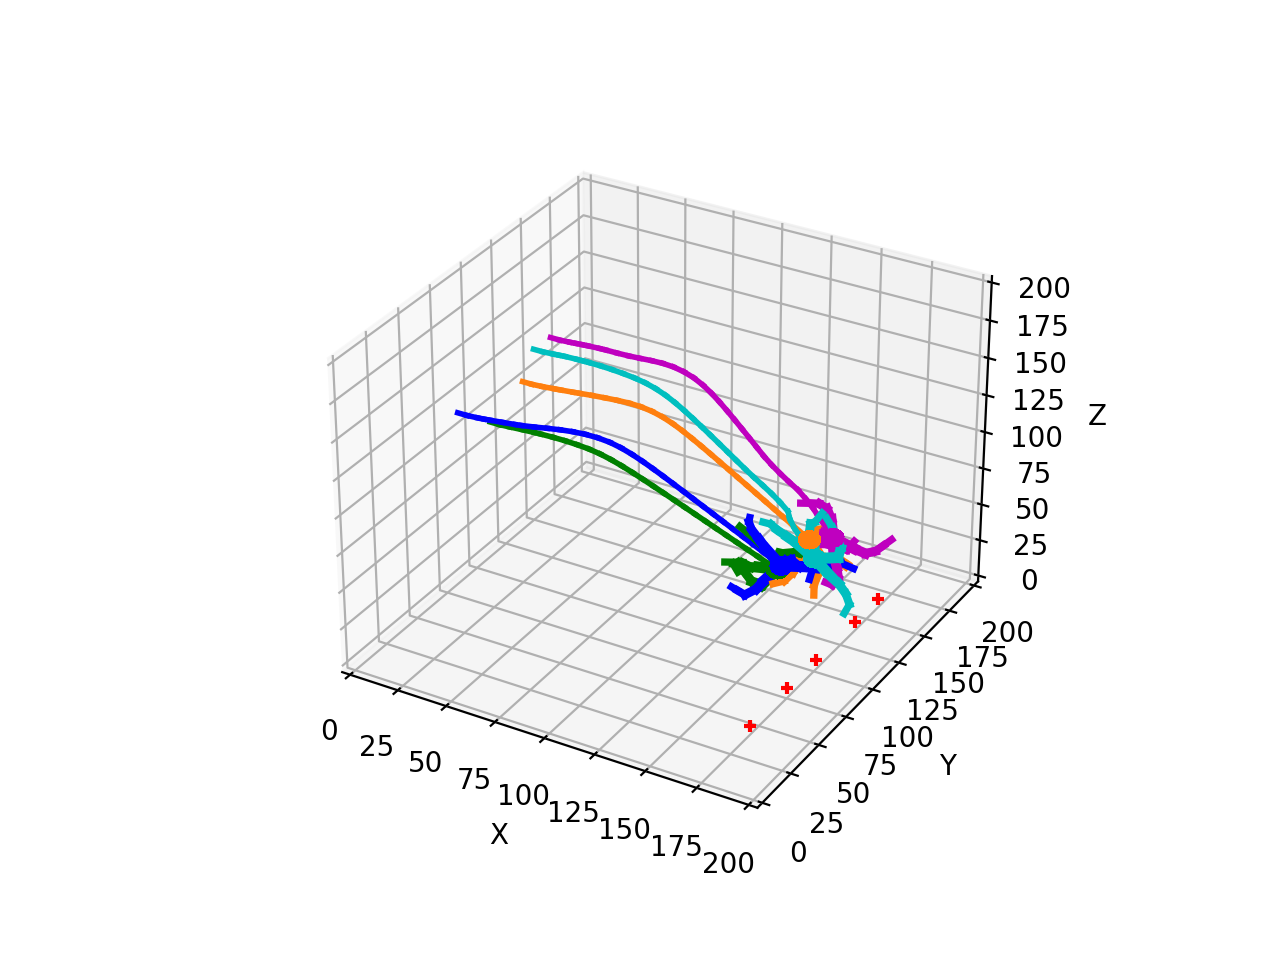

In [4]:
%matplotlib notebook

from neurodevsim.simulator import *
import numpy as np

class AMigrationFront(Front):
    
    # manage_front calls appropriate method depending on swc_type
    def manage_front(self,constellation):
        if self.swc_type == 1: # soma: check whether it can migrate or grow filipod or dendrites
            self.manage_soma(constellation)
        elif self.swc_type == 12: # filipod: grow it unless very close to attractor
            self.grow_filipod(constellation)
        elif self.swc_type == 3: # dendrites
            self.grow_dendrite(constellation)
        else:
            print ("Error: unexpected condition in extend_front")
    
    # migrate soma of grow filipod or dendrites
    def manage_soma(self,constellation):
        # first check whether we should migrate
        if self.num_children == 2: # filipod and axon children present
            children = self.get_children(constellation) # get the filipod child
            filipod = None
            for child in children:
                if child.swc_type == 12:
                    filipod = child
            if not filipod:
                print ("Error:",self.get_neuron_name(constellation),"no filipod for 2 children")
                return
            if (filipod.num_children == 1) or self.is_status1(): # filipod has a child or arrived -> migrate
                # migrate to filipod position and extend trailing axon
                try:
                    coordinate = self.migrate_soma(constellation,None,filipod=True,trailing_axon=True)
                    # success -> self.has_moved() is True
                except (GridCompetitionError):
                    #print ("Error:",self.get_neuron_name(constellation),"soma GridCompetitionError",self.has_moved())                    
                    return # try again next cycle
                except (CollisionError,ActiveChildError):
                    print ("Error:",self.get_neuron_name(constellation),"soma cannot migrate",self.has_moved())                    
                    # try again next cycle if this is the first instance
                    if (not self.has_moved()) and (self.orig.x > 50.): # second failed attempt: delete filipod
                        print (self.get_neuron_name(constellation),"soma retracts filipodium")
                        self.retract_branch(constellation,filipod)
        elif self.num_children == 0: # make first filipod child and axon, fixed growth
                # make filipod
                new_pos = self.orig + Point(10.,2.,0)
                try:
                    fili = self.add_child(constellation,new_pos,radius=1.5,swc_type=12,branch_name="filipod")
                except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                    print ("Error:",self.get_neuron_name(constellation),"soma cannot make initial filipodium")
                    return # try again next cycle
                # make axon
                count = 0
                new_pos = self.orig - Point(10.,0.,0.)
                while count < 50:
                    try:
                        pos = new_pos + unit_sample_on_sphere() * count / 10.
                        axon = self.add_child(constellation,pos,radius=1.,swc_type=2,branch_name="axon")
                        axon.disable(constellation) # axon does not grow by itself
                        return # done
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                        continue
                print ("Error:",self.get_neuron_name(constellation),"soma cannot make initial axon")        
        elif self.num_children == 1: # no filipod child: either make filipod or dendrites
            # check whether arrived to attractor
            if self.is_status1(): # filipod flagged arrival: make dendrites
                points = self.unit_branching_sample(10) # generate more points than needed
                num_dend = 0 # count number of dendrites
                for p in points: # make 4 dendrites
                    new_pos = self.orig + p * (6.0 + self.radius)
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=2.0,swc_type=3,branch_name="dendrite")
                        num_dend += 1
                        if num_dend == 4: # enough dendrites made
                            # make soma inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            #print (self.get_neuron_name(constellation),"final return")
                            return # completed this call
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                         continue # pick another point, no attempt to correct the error
            else: # make a filipod based on attraction
                self.grow_filipod(constellation)
        else:
            print ("Error:",self.get_neuron_name(constellation),"child count",self.num_children)                    
   
    # check whether filipod should continue to grow and do so
    def grow_filipod(self,constellation):
        # attract by attractor, get distant information
        attraction = self.get_substrates(constellation,"attractor",max_distance=200)
        if attraction: # attractor detected: check concentration\
            n_mols,adir = diff_gradient_to(self.end,attraction,constellation.cycle)
            # negative x means we passed the attractor
            if (adir.x < 0) or (n_mols >= 3800): # close to attractor, end filipod growth
                soma = self.get_soma(constellation)
                soma.set_status1() # flag soma that filipod has arrived: safe because nobody else sets flag
                self.disable(constellation)
                return # no growth
        else:
            n_mols = 0
         # try to make a new filipod
        count = 0
        while count < 50:
            rnd_dir = self.unit_heading_sample(width=min(60.,5. + count))
            if n_mols == 0:  # cannot be detected
                if self.swc_type == 1: # call by the soma: no heading
                    new_pos = self.orig + Point(10.,2.,0) + rnd_dir
                else:
                    new_pos = self.end + rnd_dir * 3.
            elif n_mols < 50: # far away: scale noise to n_mols
                scale = min(5.5,n_mols*0.1)
                new_pos = self.end + rnd_dir * (6.0-scale) + adir * scale 
            elif n_mols < 3800: # closer: limit noise if not colliding
                scale = max(0.1,count*0.5)
                new_pos = self.end + rnd_dir * scale + adir * (6.0-scale) 
            else: # arrived
                print ("Error in arrived",self.get_neuron_name(constellation))
            # check for possible collisions
            try:
                new_front = self.add_child(constellation,new_pos,radius=1.5,swc_type=12,branch_name="filipod")
                if self.swc_type == 12: 
                    self.disable(constellation) # success -> disable self if filipod
                return # success
            except (GridCompetitionError,InsideParentError,VolumeError):
                count += 1
                continue # generate another new_pos, no attempt to correct the error
            except CollisionError as error:
                #print (constellation.cycle,self,"fili collides with",error.collider)
                if error.collider.is_migrating(): # collision with another migrating soma
                    # best strategy is to wait till this front has passed
                    return
                count += 1
                points = self.solve_collision(constellation,new_pos,error,half_arc=True)
                #print (self.get_neuron_name(constellation),count,self._fid,"soma-fili solve_collision returns",points)
                if points: # one or more points was returned
                    try:
                        new_fronts = self.add_branch(constellation,points)
                        self.disable(constellation) # success -> disable self
                        return # success
                    except CollisionError as error:
                        #print (self.get_neuron_name(constellation),self._fid,"soma-fili solve_collision collides with",error.collider)
                        continue # generate another new_pos, no attempt to correct the error
                    except (GridCompetitionError,InsideParentError,\
                                                        VolumeError):
                        #print (self.get_neuron_name(constellation),self._fid,"soma-fili solve_collision other error")
                        continue # generate another new_pos, no attempt to correct the error
        # growth failed
        #print (self.get_neuron_name(constellation),self._fid,self.has_grown(),"fili growth failed")
        if (self.swc_type == 12) and ((constellation.cycle - self.birth) > 2): # this was second failed attempt
            self.enable_parent(constellation,growing=True) # make parent filipod grow again
            self.retract(constellation) # retract this front

    # check whether dendrite should continue to grow and do so
    def grow_dendrite(self,constellation):
        if self.path_length >= 30:  # terminus: stop growing
            self.disable(constellation)
            return
        count = 0
        while count < 50:
            # random component
            rnd_dir = self.unit_heading_sample()
            new_pos = self.end + rnd_dir * 6.0
            rad = self.taper(0.9)
            # check for possible collisions
            try:
                new_front = self.add_child(constellation,new_pos,radius=rad)
                self.disable(constellation) # success -> disable self
                return
            except CollisionError as error:
                points = self.solve_collision(constellation,new_pos,error,half_arc=True)
                #print (self.get_neuron_name(constellation),"dend solve_collision returns",points)
                if points: # one or more points was returned
                    try:
                        new_fronts = self.add_branch(constellation,points)
                        self.disable(constellation) # success -> disable self
                        return
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                        count += 1
                        continue # generate another new_pos, no attempt to correct the error
                else:
                    count += 1
                    continue # generate another new_pos
            except (GridCompetitionError,InsideParentError,VolumeError):
                count += 1
                continue # generate another new_pos, no attempt to correct the error
        # failed but do not consider this as an error
        if (constellation.cycle - self.birth) > 2: # this was second failed attempt
            self.disable(constellation) # stop trying
            
if __name__ == '__main__':
    # initialize Admin_agent
    fname = "output/amigration.db"
    sim_volume = [[0., 0., 0.], [200.0,200.0,200.0]]
    neuron_types = [AMigrationFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True,soma_black=False)

    # make list of substrate
    subs = []
    for n in range(5):
        y = 10 + n * 30 + 10 * np.random.random()
        # start attractor diffusion prior to begin of simulation
        sub = Substrate("attractor",Point(190,y,30),-50,int(1e10),rate=0.,diff_c=15.)
        subs.append(sub)
    # add substrate to simulation
    admin.add_substrate(subs)
        
    # make 5 somata and set neuron name
    admin.add_neurons(AMigrationFront,"granule_cell",5,[[10,40,70],[20,160,120]],5.,migrating=True,grid=[1,10,5,1.])

    # run the simulation
    admin.simulation_loop(100)

    # clean up
    admin.destruction()

## Colored_migration
Similar to the previous example with a trailing axon, but filipods are now colored to encode the amount of attractor they perceive. This requires a new attribute *local_attractor*.  

On fast computers the simulation may run so fast that the effect is difficult to see, therefore a movie of this simulation named **cmigration.mp4** is available in the *plots and movies* directory. The code that made this movie from the database is in *plots_and_movies.py*.

<IPython.core.display.Javascript object>


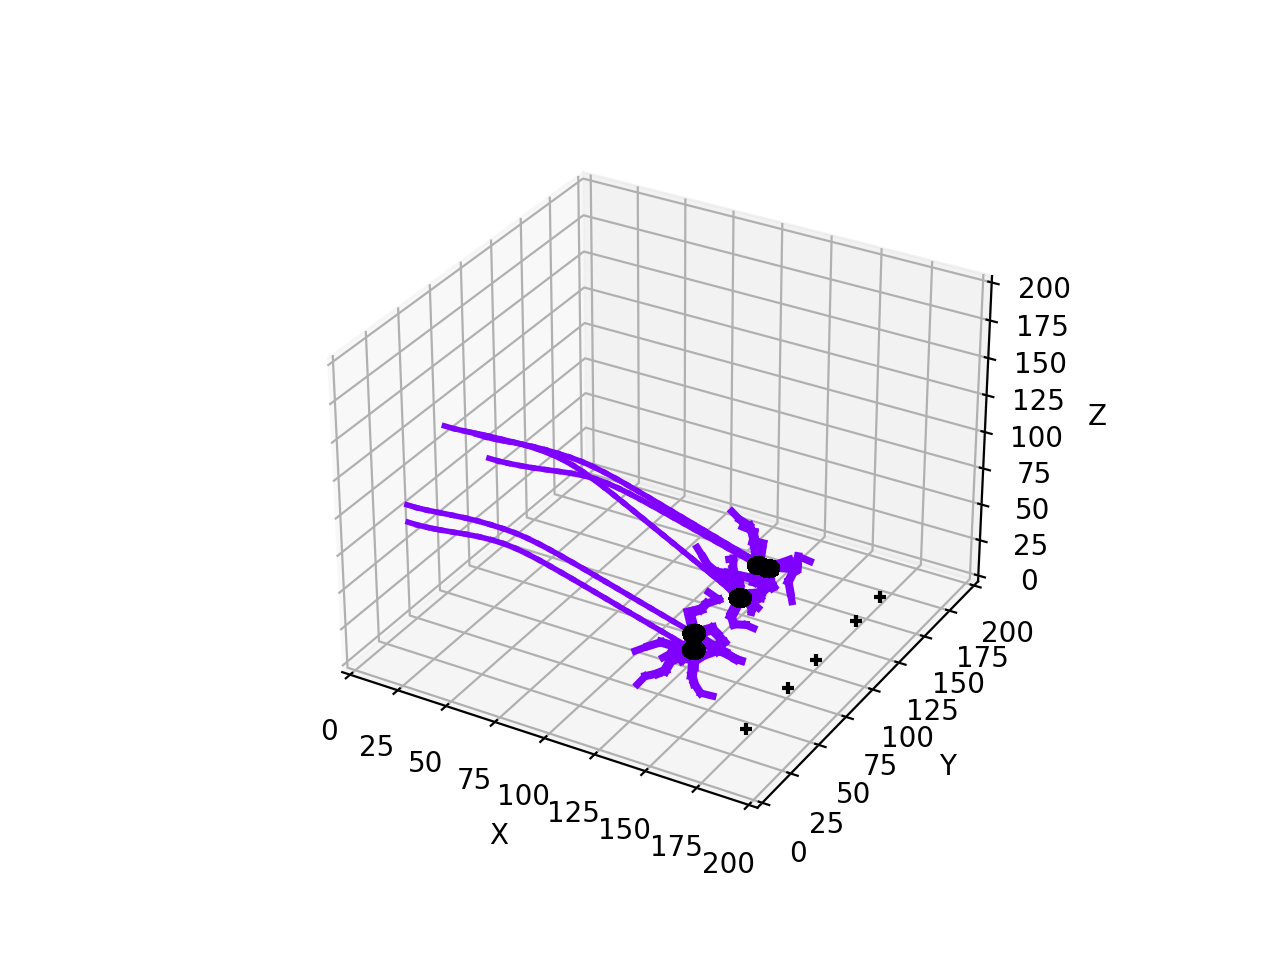

In [5]:
%matplotlib notebook

from neurodevsim.simulator import *
import numpy as np

class AMigrationFront(Front):
    # extra attributes initalized that stores local attractor concentration
    _fields_ = Front._fields_ + [('local_attractor',c_int)]
   
    # manage_front calls appropriate method depending on swc_type
    def manage_front(self,constellation):
        if self.swc_type == 1: # soma: check whether it can migrate or grow filipod or dendrites
            self.manage_soma(constellation)
        elif self.swc_type == 12: # filipod: grow it unless very close to attractor
            self.grow_filipod(constellation)
        elif self.swc_type == 3: # dendrites
            self.grow_dendrite(constellation)
        else:
            print ("Error: unexpected condition in extend_front")
    
    # migrate soma of grow filipod or dendrites
    def manage_soma(self,constellation):
        # first check whether we should migrate
        if self.num_children == 2: # filipod and axon children present
            children = self.get_children(constellation) # get the filipod child
            filipod = None
            for child in children:
                if child.swc_type == 12:
                    filipod = child
            if not filipod:
                print ("Error:",self.get_neuron_name(constellation),"no filipod for 2 children")
                return
            if (filipod.num_children == 1) or self.is_status1(): # filipod has a child or arrived -> migrate
                # migrate to filipod position and extend trailing axon
                try:
                    coordinate = self.migrate_soma(constellation,None,filipod=True,trailing_axon=True)
                    # success -> self.has_moved() is True
                except (GridCompetitionError):
                    #print ("Error:",self.get_neuron_name(constellation),"soma GridCompetitionError",self.has_moved())                    
                    return # try again next cycle
                except (CollisionError,ActiveChildError):
                    print ("Error:",self.get_neuron_name(constellation),"soma cannot migrate",self.has_moved())                    
                    # try again next cycle if this is the first instance
                    if (not self.has_moved()) and (self.orig.x > 50.): # second failed attempt: delete filipod
                        print (self.get_neuron_name(constellation),"soma retracts filipodium")
                        self.retract_branch(constellation,filipod)
        elif self.num_children == 0: # make first filipod child and axon, fixed growth
                # make filipod
                new_pos = self.orig + Point(10.,2.,0)
                try:
                    fili = self.add_child(constellation,new_pos,radius=1.5,swc_type=12,branch_name="filipod")
                except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                    print ("Error:",self.get_neuron_name(constellation),"soma cannot make initial filipodium")
                    return # try again next cycle
                # make axon
                count = 0
                new_pos = self.orig - Point(10.,0.,0.)
                while count < 50:
                    try:
                        pos = new_pos + unit_sample_on_sphere() * count / 10.
                        axon = self.add_child(constellation,pos,radius=1.,swc_type=2,branch_name="axon")
                        axon.disable(constellation) # axon does not grow by itself
                        return # done
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                        continue
                print ("Error:",self.get_neuron_name(constellation),"soma cannot make initial axon")        
        elif self.num_children == 1: # no filipod child: either make filipod or dendrites
            # check whether arrived to attractor
            if self.is_status1(): # filipod flagged arrival: make dendrites
                points = self.unit_branching_sample(10) # generate more points than needed
                num_dend = 0 # count number of dendrites
                for p in points: # make 4 dendrites
                    new_pos = self.orig + p * (6.0 + self.radius)
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=2.0,swc_type=3,branch_name="dendrite")
                        num_dend += 1
                        if num_dend == 4: # enough dendrites made
                            # make soma inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            #print (self.get_neuron_name(constellation),"final return")
                            return # completed this call
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                         continue # pick another point, no attempt to correct the error
            else: # make a filipod based on attraction
                self.grow_filipod(constellation)
        else:
            print ("Error:",self.get_neuron_name(constellation),"child count",self.num_children)                    
   
    # check whether filipod should continue to grow and do so
    def grow_filipod(self,constellation):
        # attract by attractor, get distant information
        attraction = self.get_substrates(constellation,"attractor",max_distance=200)
        if attraction: # attractor detected: check concentration
            n_mols,adir = diff_gradient_to(self.end,attraction,constellation.cycle)
            # negative x means we passed the attractor
            if (adir.x < 0) or (n_mols >= 3800): # close to attractor, end filipod growth
                soma = self.get_soma(constellation)
                soma.set_status1() # flag soma that filipod has arrived: safe because nobody else sets flag
                self.disable(constellation)
                return # no growth
        else:
            n_mols = 0
         # try to make a new filipod
        count = 0
        self.local_attractor = n_mols
        while count < 50:
            rnd_dir = self.unit_heading_sample(width=min(60.,5. + count))
            if n_mols == 0:  # cannot be detected
                if self.swc_type == 1: # call by the soma: no heading
                    new_pos = self.orig + Point(10.,2.,0) + rnd_dir
                else:
                    new_pos = self.end + rnd_dir * 3.
            elif n_mols < 50: # far away: scale noise to n_mols
                scale = min(5.5,n_mols*0.1)
                new_pos = self.end + rnd_dir * (6.0-scale) + adir * scale 
            elif n_mols < 3800: # closer: limit noise if not colliding
                scale = max(0.1,count*0.5)
                new_pos = self.end + rnd_dir * scale + adir * (6.0-scale) 
            else: # arrived
                print ("Error in arrived",self.get_neuron_name(constellation))
            # check for possible collisions
            try:
                new_front = self.add_child(constellation,new_pos,radius=1.5,swc_type=12,branch_name="filipod")
                new_front.local_attractor = n_mols
                if self.swc_type == 12: 
                    self.disable(constellation) # success -> disable self if filipod
                return # success
            except (GridCompetitionError,InsideParentError,VolumeError):
                count += 1
                continue # generate another new_pos, no attempt to correct the error
            except CollisionError as error:
                #print (constellation.cycle,self,"fili collides with",error.collider)
                if error.collider.is_migrating(): # collision with another migrating soma
                    # best strategy is to wait till this front has passed
                    return
                count += 1
                points = self.solve_collision(constellation,new_pos,error,half_arc=True)
                #print (self.get_neuron_name(constellation),count,self._fid,"soma-fili solve_collision returns",points)
                if points: # one or more points was returned
                    try:
                        new_fronts = self.add_branch(constellation,points)
                        self.disable(constellation) # success -> disable self
                        return # success
                    except CollisionError as error:
                        #print (self.get_neuron_name(constellation),self._fid,"soma-fili solve_collision collides with",error.collider)
                        continue # generate another new_pos, no attempt to correct the error
                    except (GridCompetitionError,InsideParentError,\
                                                        VolumeError):
                        #print (self.get_neuron_name(constellation),self._fid,"soma-fili solve_collision other error")
                        continue # generate another new_pos, no attempt to correct the error
        # growth failed
        #print (self.get_neuron_name(constellation),self._fid,self.has_grown(),"fili growth failed")
        if (self.swc_type == 12) and ((constellation.cycle - self.birth) > 2): # this was second failed attempt
            self.enable_parent(constellation,growing=True) # make parent filipod grow again
            self.retract(constellation) # retract this front

    # check whether dendrite should continue to grow and do so
    def grow_dendrite(self,constellation):
        if self.path_length >= 30:  # terminus: stop growing
            self.disable(constellation)
            return
        count = 0
        while count < 50:
            # random component
            rnd_dir = self.unit_heading_sample()
            new_pos = self.end + rnd_dir * 6.0
            rad = self.taper(0.9)
            # check for possible collisions
            try:
                new_front = self.add_child(constellation,new_pos,radius=rad)
                self.disable(constellation) # success -> disable self
                return
            except CollisionError as error:
                points = self.solve_collision(constellation,new_pos,error,half_arc=True)
                #print (self.get_neuron_name(constellation),"dend solve_collision returns",points)
                if points: # one or more points was returned
                    try:
                        new_fronts = self.add_branch(constellation,points)
                        self.disable(constellation) # success -> disable self
                        return
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                        count += 1
                        continue # generate another new_pos, no attempt to correct the error
                else:
                    count += 1
                    continue # generate another new_pos
            except (GridCompetitionError,InsideParentError,VolumeError):
                count += 1
                continue # generate another new_pos, no attempt to correct the error
        # failed but do not consider this as an error
        if (constellation.cycle - self.birth) > 2: # this was second failed attempt
            self.disable(constellation) # stop trying
            
if __name__ == '__main__':
    # initialize Admin_agent
    fname = "output/cmigration.db"
    sim_volume = [[0., 0., 0.], [200.0,200.0,200.0]]
    neuron_types = [AMigrationFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True,soma_black=False,color_scheme=3,color_data=['local_attractor',0,4000])

    # make list of substrate
    subs = []
    for n in range(5):
        y = 10 + n * 30 + 10 * np.random.random()
        # start attractor diffusion prior to begin of simulation
        sub = Substrate("attractor",Point(190,y,30),-50,int(1e10),rate=0.,diff_c=15.)
        subs.append(sub)
    # add substrate to simulation
    admin.add_substrate(subs)
        
    # make 5 somata and set neuron name
    admin.add_neurons(AMigrationFront,"granule_cell",5,[[10,40,70],[20,160,120]],5.,migrating=True,grid=[1,10,5,1.])

    # save local_attractor attribute during the simulation so that movies can be made
    admin.attrib_to_db(AMigrationFront,"local_attractor","int")

    # run the simulation
    admin.simulation_loop(100)

    # clean up
    admin.destruction()

## Filipod_axon_block_migration
Similar to the [Filipod_axon_migration](#Filipod_axon_migration) example but the migrating somata also need to pass around a set of large immobile somata that repulse the approaching granule cells.

<IPython.core.display.Javascript object>


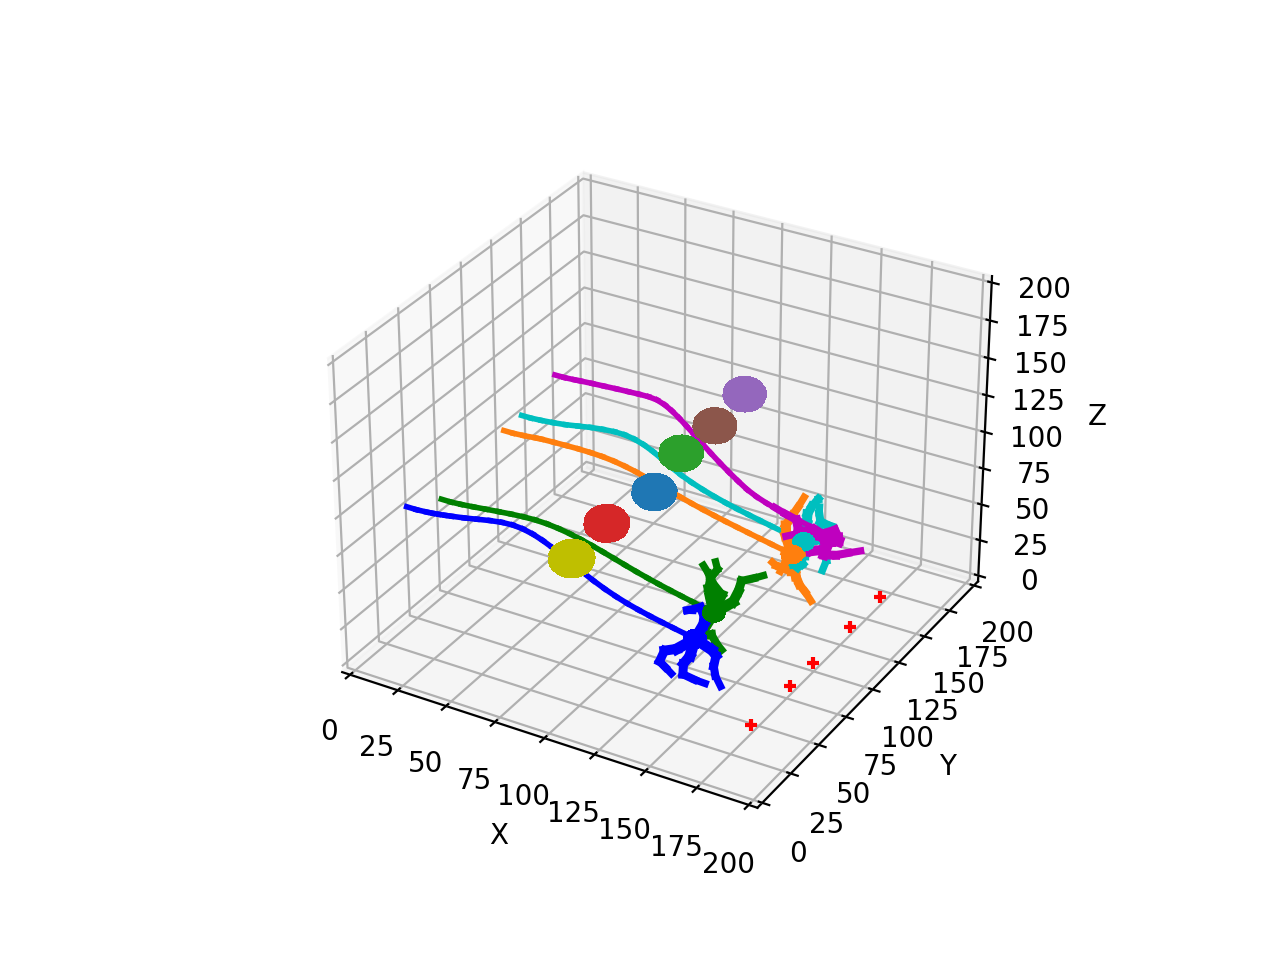

In [3]:
%matplotlib notebook

from neurodevsim.simulator import *
import numpy as np

class AMigrationFront(Front):
    
    # manage_front calls appropriate method depending on swc_type
    def manage_front(self,constellation):
        if self.swc_type == 1: # soma: check whether it can migrate or grow filipod or dendrites
            self.manage_soma(constellation)
        elif self.swc_type == 12: # filipod: grow it unless very close to attractor
            self.grow_filipod(constellation)
        elif self.swc_type == 3: # dendrites
            self.grow_dendrite(constellation)
        else:
            print ("Error: unexpected condition in extend_front")
    
    # migrate soma of grow filipod or dendrites
    def manage_soma(self,constellation):
        # first check whether we should migrate
        if self.num_children == 2: # filipod and axon children present
            children = self.get_children(constellation) # get the filipod child
            filipod = None
            for child in children:
                if child.swc_type == 12:
                    filipod = child
            if not filipod:
                print ("Error:",self.get_neuron_name(constellation),"no filipod for 2 children")
                return
            if (filipod.num_children == 1) or self.is_status1(): # filipod has a child or arrived -> migrate
                # migrate to filipod position and extend trailing axon
                try:
                    coordinate = self.migrate_soma(constellation,None,filipod=True,trailing_axon=True)
                    # success -> self.has_moved() is True
                except (GridCompetitionError):
                    #print ("Error:",self.get_neuron_name(constellation),"soma GridCompetitionError",self.has_moved())                    
                    return # try again next cycle
                except (CollisionError,ActiveChildError):
                    print ("Error:",self.get_neuron_name(constellation),"soma cannot migrate",self.has_moved())                    
                    # try again next cycle if this is the first instance
                    if (not self.has_moved()) and (self.orig.x > 50.): # second failed attempt: delete filipod
                        #print (self.get_neuron_name(constellation),"soma retracts filipodium")
                        self.retract_branch(constellation,filipod)
        elif self.num_children == 0: # make first filipod child and axon, fixed growth
                # make filipod
                new_pos = self.orig + Point(10.,2.,0)
                try:
                    fili = self.add_child(constellation,new_pos,radius=1.5,swc_type=12,branch_name="filipod")
                except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                    print ("Error:",self.get_neuron_name(constellation),"soma cannot make initial filipodium")
                    return # try again next cycle
                # make axon
                count = 0
                new_pos = self.orig - Point(10.,0.,0.)
                while count < 50:
                    try:
                        pos = new_pos + unit_sample_on_sphere() * count / 10.
                        axon = self.add_child(constellation,pos,radius=1.,swc_type=2,branch_name="axon")
                        axon.disable(constellation) # axon does not grow by itself
                        return # done
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                        continue
                print ("Error:",self.get_neuron_name(constellation),"soma cannot make initial axon")
        elif self.num_children == 1: # no filipod child: either make filipod or dendrites
            # check whether arrived to attractor
            if self.is_status1(): # filipod flagged arrival: make dendrites
                points = self.unit_branching_sample(10) # generate more points than needed
                num_dend = 0 # count number of dendrites
                for p in points: # make 4 dendrites
                    new_pos = self.orig + p * (6.0 + self.radius)
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=2.0,swc_type=3,branch_name="dendrite")
                        num_dend += 1
                        if num_dend == 4: # enough dendrites made
                            # make soma inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            #print (self.get_neuron_name(constellation),"final return")
                            return # completed this call
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                         continue # pick another point, no attempt to correct the error
            else: # make a filipod based on attraction
                self.grow_filipod(constellation)
        else:
            print ("Error:",self.get_neuron_name(constellation),"child count",self.num_children)                    
   
    # check whether filipod should continue to grow and do so
    def grow_filipod(self,constellation):
        # attract by attractor, get distant information
        attraction = self.get_substrates(constellation,"attractor",max_distance=200)
        if attraction: # attractor detected: check concentration
            n_mols,adir = diff_gradient_to(self.end,attraction,constellation.cycle)
            # negative x means we passed the attractor
            if (adir.x < 0) or (n_mols >= 3800): # close to attractor, end filipod growth
                soma = self.get_soma(constellation)
                soma.set_status1() # flag soma that filipod has arrived: safe because nobody else sets flag
                self.disable(constellation)
                return # no growth
        else:
            n_mols = 0
        # repelled by other neurons
        block = self.get_fronts(constellation,what='name',name="blocker",max_distance=50)
        if len(block) == 0: # no blocking structures nearby
            dir_to_block = Point(0.,0.,0.)
        else:  # compute direction independent of distance
            direction = block[0][0].orig - self.end
            distance = block[0][1]
            # make dir_to_block increase as blocker gets closer
            dir_to_block = direction.norm() * ((50.0 - distance)/10.0)
         # try to make a new filipod
        count = 0
        while count < 50:
            rnd_dir = self.unit_heading_sample(width=min(60.,5. + count))
            if n_mols == 0:  # cannot be detected
                if self.swc_type == 1: # call by the soma: no heading
                    new_pos = self.orig + Point(10.,2.,0) + rnd_dir
                else:
                    new_pos = self.end + (rnd_dir - dir_to_block) * 3.
            elif n_mols < 50: # far away: scale noise to n_mols
                scale = min(5.5,n_mols*0.1)
                new_pos = self.end + rnd_dir * (6.0-scale) + adir * scale - dir_to_block
            elif n_mols < 3800: # closer: limit noise if not colliding
                scale = max(0.1,count*0.5)
                new_pos = self.end + rnd_dir * scale + adir * (6.0-scale) - dir_to_block
            else: # arrived
                print ("Error in arrived",self.get_neuron_name(constellation))
            # check for possible collisions
            try:
                new_front = self.add_child(constellation,new_pos,radius=1.5,swc_type=12,branch_name="filipod")
                if self.swc_type == 12: 
                    self.disable(constellation) # success -> disable self if filipod
                return # success
            except (GridCompetitionError,InsideParentError,VolumeError):
                count += 1
                continue # generate another new_pos, no attempt to correct the error
            except CollisionError as error:
                #print (constellation.cycle,self,"fili collides with",error.collider)
                if error.collider.is_migrating(): # collision with another migrating soma
                    # best strategy is to wait till this front has passed
                    return
                count += 1
                points = self.solve_collision(constellation,new_pos,error,half_arc=True)
                #print (self.get_neuron_name(constellation),count,self._fid,"soma-fili solve_collision returns",points)
                if points: # one or more points was returned
                    try:
                        new_fronts = self.add_branch(constellation,points)
                        self.disable(constellation) # success -> disable self
                        return # success
                    except CollisionError as error:
                        #print (self.get_neuron_name(constellation),self._fid,"soma-fili solve_collision collides with",error.collider)
                        continue # generate another new_pos, no attempt to correct the error
                    except (GridCompetitionError,InsideParentError,\
                                                        VolumeError):
                        #print (self.get_neuron_name(constellation),self._fid,"soma-fili solve_collision other error")
                        continue # generate another new_pos, no attempt to correct the error
        # growth failed
        #print (self.get_neuron_name(constellation),self._fid,self.has_grown(),"fili growth failed")
        if (self.swc_type == 12) and ((constellation.cycle - self.birth) > 2): # this was second failed attempt
            self.enable_parent(constellation,growing=True) # make parent filipod grow again
            self.retract(constellation) # retract this front

    # check whether dendrite should continue to grow and do so
    def grow_dendrite(self,constellation):
        if self.path_length >= 30:  # terminus: stop growing
            self.disable(constellation)
            return
        count = 0
        while count < 50:
            # random component
            rnd_dir = self.unit_heading_sample()
            new_pos = self.end + rnd_dir * 6.0
            rad = self.taper(0.9)
            # check for possible collisions
            try:
                new_front = self.add_child(constellation,new_pos,radius=rad)
                self.disable(constellation) # success -> disable self
                return
            except CollisionError as error:
                points = self.solve_collision(constellation,new_pos,error,half_arc=True)
                #print (self.get_neuron_name(constellation),"dend solve_collision returns",points)
                if points: # one or more points was returned
                    try:
                        new_fronts = self.add_branch(constellation,points)
                        self.disable(constellation) # success -> disable self
                        return
                    except (CollisionError,GridCompetitionError,InsideParentError,VolumeError):
                        count += 1
                        continue # generate another new_pos, no attempt to correct the error
                else:
                    count += 1
                    continue # generate another new_pos
            except (GridCompetitionError,InsideParentError,VolumeError):
                count += 1
                continue # generate another new_pos, no attempt to correct the error
        # failed but do not consider this as an error
        if (constellation.cycle - self.birth) > 2: # this was second failed attempt
            self.disable(constellation) # stop trying
            
# Neuron that will block migration of other ones
class BigFront(Front):
    
    # No additional fronts -> disable
    def manage_front(self,constellation):
        self.disable(constellation)

if __name__ == '__main__':
    # initialize Admin_agent
    fname = "output/bmigration.db"
    sim_volume = [[0., 0., 0.], [200.0,200.0,200.0]]
    neuron_types = [AMigrationFront,BigFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True,soma_black=False)

    # make list of substrate
    subs = []
    for n in range(5):
        y = 10 + n * 30 + 10 * np.random.random()
        # start attractor diffusion prior to begin of simulation
        sub = Substrate("attractor",Point(190,y,30),-50,int(1e10),rate=0.,diff_c=15.)
        subs.append(sub)
    # add substrate to simulation
    admin.add_substrate(subs)
        
    # make 5 somata and set neuron name
    admin.add_neurons(AMigrationFront,"granule_cell",5,[[10,40,70],[20,160,120]],5.,migrating=True,grid=[1,10,5,1.])
    # make 6 blocking neurons on a grid and set neuron name
    admin.add_neurons(BigFront,"blocker",6,[[100,20,100],[100,180,100]],10,grid=[1,6,1,2.])
    # run the simulation
    admin.simulation_loop(50)

    # clean up
    admin.destruction()